## This notebook is an implementation of my original sonification mapping with the Strauss package. In this mapping, I map n's to notes and m's to octaves, where lower ns and ms equal lower tones. I add together the sine and cosine coefficients and play a given n and m combination when the sum of the coefficients is above 2.5% of the maximum. This ends up sounding like chords. I use different instruments for positive and negative coefficient sums, which builds some depth. Strauss won't play to sounds at once, so I build out a bit of extra functionality to combine the sonifications into one.

## to do:
- incorporate coefficient amplitude into the volume
- maybe do away with positive/negative?
- try out other mappings (see Overleaf)

In [1]:
import matplotlib.pyplot as plt
import strauss
from strauss.sonification import Sonification
from strauss.sources import Objects
from strauss.generator import Generator
from strauss import channels
from strauss.generator import Sampler
from strauss.score import Score
from strauss.generator import Synthesizer
import IPython.display as ipd
from strauss.sources import Events
import os
from scipy.interpolate import interp1d
import numpy as np
import copy
import wavio as wav

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from mike_code import LaguerreAmplitudes
from functionalities import *
import matplotlib.cm as cm
from skimage.transform import resize_local_mean
from combine_sonifications import combine_save_sonifications

In [2]:
#getting a list of all of the sounds in this soundfont
#listall= Sampler("ChateauGrand-Plus-Instruments-bs16i-v4.sf2")
cello = Sampler("ChateauGrand-Plus-Instruments-bs16i-v4.sf2", sf_preset=71) 
# Not all soundfonts will work here! I need the soundfont to have the same range of frequencies as the piano. I type out some presets that 
#work below, though there are varying degrees of how good they sound
#1 works, 10 works, 11 works, 19 works, 22 works, 36 (trumpet) works, 40 works but is bad, 42 works, 47 works pretty well, 
#50 works p well, 62 works, 70 works, 71 works
piano = Sampler("ChateauGrand-Plus-Instruments-bs16i-v4.sf2", sf_preset=5)

In [3]:
cello_generator = copy.copy(cello)
piano_generator = copy.copy(piano)

returning coscoefs, sincoefs
max, min, median of reconstruction: 292.0181285732433 -2.03190240435129 55.35175148427129
max, min, median of original image: 254.99999999999997 0.0 54.13048035730565
returning reconstruction, cosine coefficients, and sine coefficients


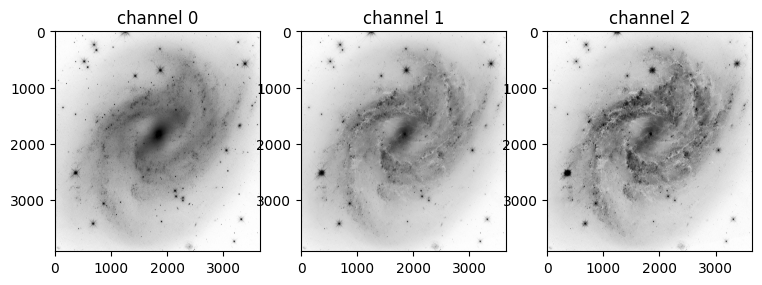

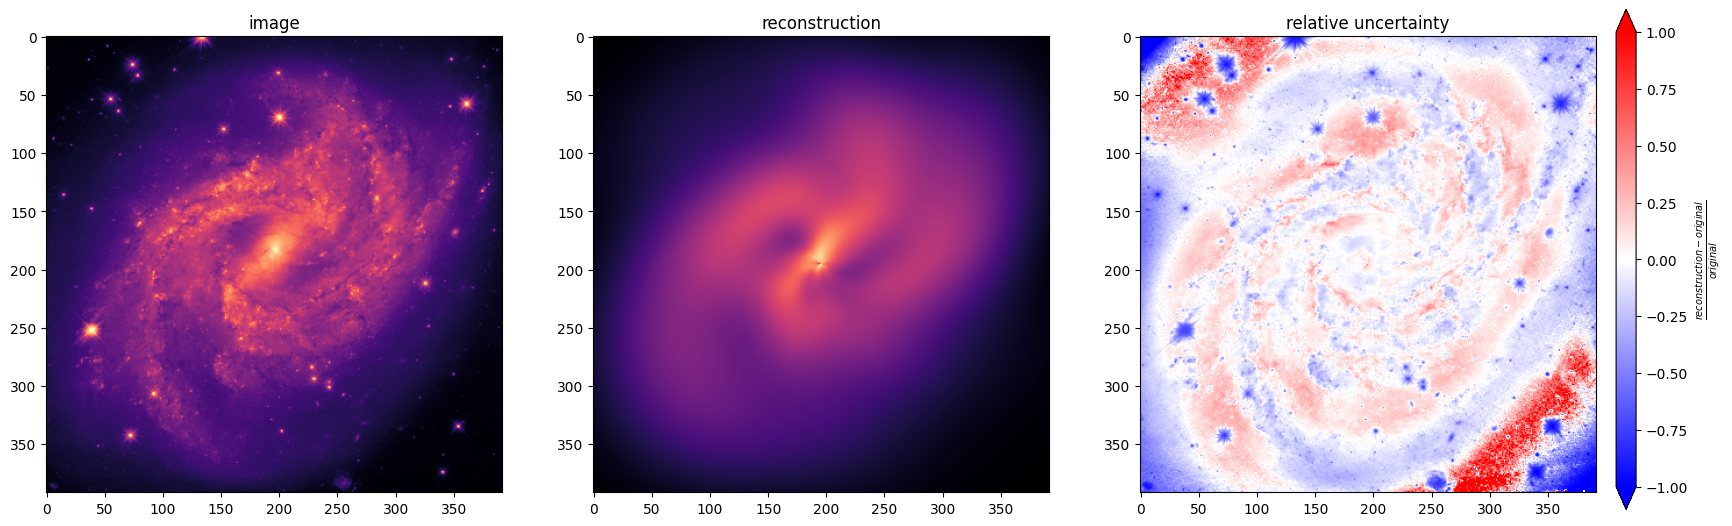

In [4]:
spiral_recon, spiral_cos_cos, spiral_sin_cos = beef_it('ngc2525.jpg', rescale_factor=.1, 
                                  rscale=500, recon_lims=3000)

In [7]:

def mod_map_to_sounds(cos_cos, sin_cos):
    note_list = np.array(['G','Ab','F','F#','E','D','D#','C','C#','B','A','A#']) 
    #pythagorean chromatic scale, longer than our needed 12 notes but lets us grow to n = 17 if wanted/needed?
    #from wiki: In Pythagorean tuning (i.e. 3-limit just intonation) the chromatic scale is tuned as follows, 
    #in perfect fifths from G♭ to A♯ centered on D (in bold) (G♭–D♭–A♭–E♭–B♭–F–C–G–D–A–E–B–F♯–C♯–G♯–D♯–A♯)
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = cos_cos + sin_cos
    abs_max = np.max(modulus)
    pos_notes = []
    pos_amplitude = []
    neg_notes = []
    neg_amplitude = []

    for m in range(mmax):
        octave = m + 1
        for n in range(nmax):
            amp = modulus[m,n]
            #print(m, n)
            if abs(amp) >= .025*abs_max: #if the amplitude of this coefficient is at least 2.5% the maximum, we will make it audible
                if amp > 0: #if the amplitude is positive, use instrument 1
                    note = note_list[n] + str(octave)
                    pos_notes.append(note)
                    pos_amplitude.append(abs(amp))
                else: #if the amplitude is negative, use instrument two
                    note = note_list[n] + str(octave)
                    neg_notes.append(note)
                    neg_amplitude.append(amp)

    print('returning full set of notes')
    return pos_notes, pos_amplitude, neg_notes, neg_amplitude

In [8]:
pos_note, pos_amplitude, neg_note, neg_amplitude = mod_map_to_sounds(spiral_cos_cos, spiral_sin_cos)
pos_note, neg_note #looking at note lists

returning full set of notes


(['G1',
  'F#1',
  'E1',
  'C#1',
  'Ab2',
  'Ab3',
  'E3',
  'D3',
  'D#3',
  'F#5',
  'E5',
  'F7'],
 ['Ab1', 'D1', 'A#1', 'G2', 'F#2', 'G3', 'F3', 'F#3', 'Ab4', 'D#5', 'E7'])

In [9]:
length = 3 #3 seconds
neg_score =  Score([neg_note], length) #make Scores out of our note lists, which I turn into chords with the '[]'  here
pos_score = Score([pos_note], length) #see https://strauss.readthedocs.io/en/latest/elements.html for explanation

In [16]:
#making a Strauss 'event' to play our chords! feed in pitch and volume being constant for each note, set time limits to 0-101%
#following their examples
pos_data = {'pitch': np.ones(len(pos_note)),
       'volume': np.ones(len(pos_note))} #eventually want to make volume scale with importance somehow
pos_sources = Events(pos_data.keys())
pos_sources.fromdict(pos_data)

neg_data = {'pitch': np.ones(len(neg_note)),
       'volume': np.ones(len(neg_note))} #eventually want to make volume scale with importance somehow
neg_sources = Events(neg_data.keys())
neg_sources.fromdict(neg_data)


lims = {'time': ('0','101')}
pos_sources.apply_mapping_functions(map_lims=lims)
neg_sources.apply_mapping_functions(map_lims=lims)


In [17]:
#rendering sonifications
system = "stereo"
pos_soni = Sonification(pos_score, pos_sources, piano_generator, system)
pos_soni.render()


system = "stereo"
neg_soni = Sonification(neg_score, neg_sources, cello_generator, system)
neg_soni.render()

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 360.08it/s]


In [18]:
pos_soni.hear() #listen to positive coefficients first
neg_soni.hear() #then negative

Playing Sonification (3 s): 
Playing Sonification (3 s): 


In [13]:
#combine sonifications and save out as a single wave file, need to import the combine_save_sonifications function
combine_save_sonifications('trial.wav', pos_soni, neg_soni, ffmpeg_output=False, master_volume=1.)

Creating temporary .wav files...
.TEMP_0.wav
.TEMP_1.wav
Joining temporary .wav files...
Cleaning up...
Saved to: trial.wav


In [15]:
import wavio as wav
import sounddevice as sd 
w = wav.read('trial.wav') #listen to our combined audio file
sd.play(w.data)
sd.wait()